In [17]:
from tensorflow import keras
from tensorflow.keras.layers import *
from prepare_data import *
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import albumentations as A

In [11]:
dataset = Dataset.eighty
dataset_name = str(dataset).split(".")[1]
raw_train, raw_val = prep_dataset(dataset, 8)

Found 27831 files belonging to 80 classes.
Using 23657 files for training.
Found 27831 files belonging to 80 classes.
Using 4174 files for validation.


In [30]:
standard_model_path = f"../model-saves/extractors/{dataset_name}/{dataset_name.upper()}-EXTRACTOR/extractor/savefile.hdf5"
standard_extractor = keras.models.load_model(standard_model_path).layers[0].layers[-1]
standard_extractor.trainable = False
for layer in standard_extractor.layers:
    layer._name += "_1"

gray_model_path = f"../model-saves/extractors/{dataset_name}/{dataset_name.upper()}-GRAY-EXTRACTOR/extractor/savefile.hdf5"
gray_extractor = keras.models.load_model(gray_model_path).layers[0].layers[-1]
gray_extractor.trainable = False
for layer in gray_extractor.layers:
    layer._name += "_2"

blur_model_path = f"../model-saves/extractors/{dataset_name}/{dataset_name.upper()}-BLUR-EXTRACTOR/extractor/savefile.hdf5"
blur_extractor = keras.models.load_model(blur_model_path).layers[0].layers[-1]
blur_extractor.trainable = False
for layer in blur_extractor.layers:
    layer._name += "_3"

standard_model = keras.Model(inputs=standard_extractor.input, outputs=standard_extractor.layers[1].output)
gray_model = keras.Model(inputs=gray_extractor.input, outputs=gray_extractor.layers[1].output)
blur_model = keras.Model(inputs=blur_extractor.input, outputs=blur_extractor.layers[1].output)

In [19]:
gray_aug = A.Compose([A.ToGray(p=1.0)])
blur_aug = A.Compose([A.Blur(p=1.0)])

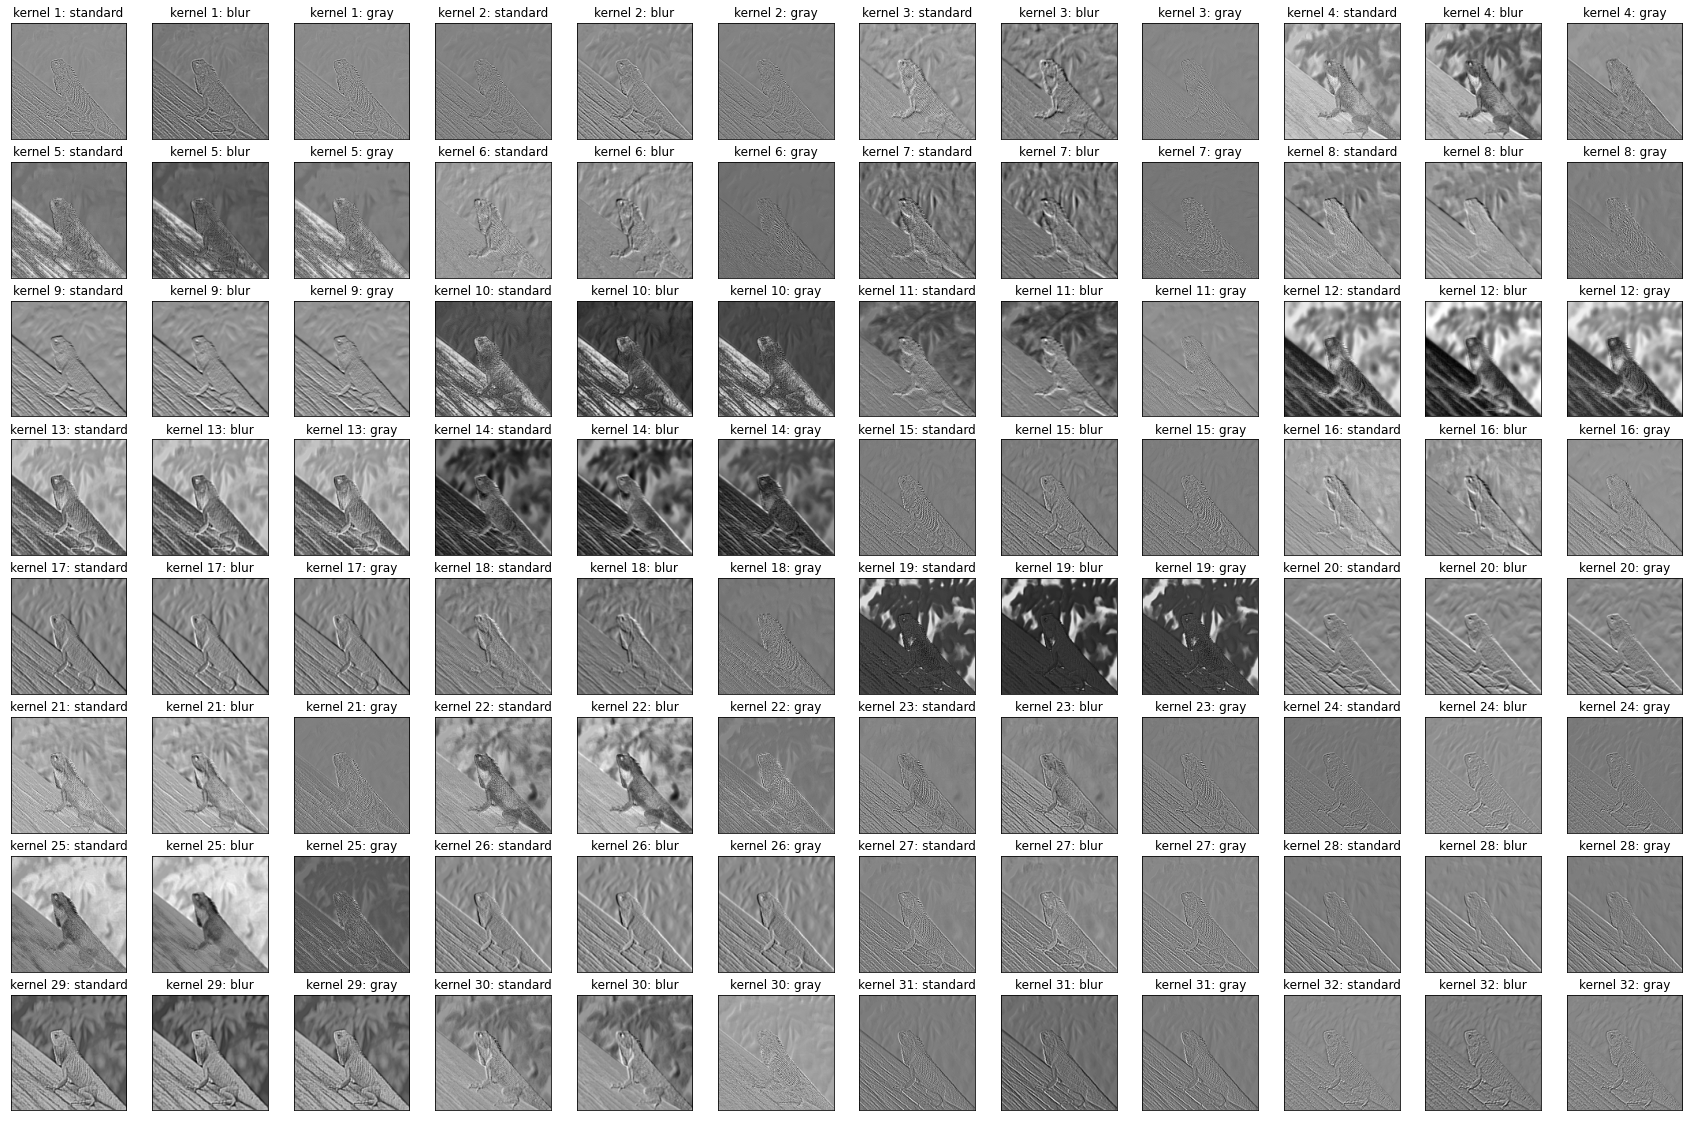

In [31]:
image = iter(raw_train).next()[0][0]
standard_img = preprocess_input(image)
blurred_img = preprocess_input(blur_aug(image=image.numpy())['image'])
grayed_img = preprocess_input(gray_aug(image=image.numpy())['image'])

standard_features = standard_model.predict(np.expand_dims(standard_img, axis=0))
blur_features = blur_model.predict(np.expand_dims(blurred_img, axis=0))
gray_features = gray_model.predict(np.expand_dims(grayed_img, axis=0))
features = []
for i in range(32):
    features.append(standard_features[0,:,:,i])
    features.append(blur_features[0,:,:,i])
    features.append(gray_features[0,:,:,i])

names = ['standard', 'blur', 'gray']

fig, ax = plt.subplots(8, 12)
fig.set_size_inches(30, 20)
for i in range(8):
    for j in range(12):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].imshow(features[12*i+j], cmap='gray')
        ax[i,j].title.set_text(f"kernel {((12*i+j)//3)+1}: {names[(12*i+j)%3]}")